#### Importing Python Modules

In [8]:
import pandas as pd 
import numpy as np 
import json as json
from pymongo import MongoClient
import nltk

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

from dateutil import parser
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png

## Important Functions

In [9]:
import datetime
epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_secs(dt):
    return (dt - epoch).total_seconds()

def unix_time_minute(dt):
    return int((dt - epoch).total_seconds()/60)




In [10]:
def getTeamOrientation(df,userInfo,homeKeys,awayKeys):
    description = userInfo.get('description')
    name = userInfo.get('name')
    screen_name = userInfo.get('screen_name')
    
    if description:
        description = description.lower().replace('#','').split()
    else:
        description = []
        
    if name:
        name = name.lower().replace('#','').split()
    else:
        name = []
    
    if screen_name:
        screen_name = screen_name.lower().split()
    else:
        screen_name= []
    
    userList = description + name + screen_name
    teamPreference = None
    
    # first loop through every userList word and try to find exact match in teamKeys
    # If not loop through words and try to find partial match on team keys
    
    for items in userList:
        if items in homeKeys:
            return 1
        elif items in awayKeys:
            return 0
    
#     # Partial Match
#     for items in userList:
        
#         for key1 in homeKeys:
#             if items in key1:
#                 return 1 
#         for key2 in awayKeys:
#             if items in key2:
#                 return 0
        
    return None

In [11]:
def getHomeVsAwayTweetCounts(df,screenName,homeKeys,awayKeys):
    temp_df = df[df['screen_name']==screenName]
    
    homeTotals = 0 
    awayTotals = 0 
    
    for tweet in temp_df['text']:
        homeTotals += totalNumOfTag(tweet,homeKeys)
        awayTotals += totalNumOfTag(tweet,awayKeys)
        
    if homeTotals >= awayTotals:
        return 1 
    else:
        return 0 
    
def totalNumOfTag(tweet,tagList):
    tweet = tweet.split()
    count = 0 
    for words in tweet:
        if words in tagList:
            count = count + 1 
    
    return count 

    

In [12]:
def getNumberOfTweets(df):
    MinuteList = df.timeStampMinutes.unique()
    
    totalTweets = []
    for minute in MinuteList:
        count = 0 
        count = df['compoundScore'][df.timeStampMinutes==minute].shape[0]
        totalTweets.append(count)
    
    return totalTweets
        

def getSummaryByMinute(df):
    MinuteList = df.timeStampMinutes.unique()

    byMinutePercentPos = []
    byMinutePercNeg = []

    byMinuteMedianPos = []
    byMinuteMedianNeg = []



    for minute in MinuteList:
        compoundList = df['compoundScore'][df.timeStampMinutes==minute]


        posCompound = [x for x in compoundList if x > 0] 
        negCompound = [x for x in compoundList if x < 0]
        
        
        #wilsonConfInterval = confidence(len(posCompound),len(negCompound))
        
        percentPositive = float(len(posCompound))/float(len(compoundList))
        percentNegative = float(len(negCompound))/float(len(compoundList))

        posScoreList = df['posScore'][(df.timeStampMinutes==minute) & (df.compoundScore > 0)]
        medianPosScore = np.median(posScoreList)

        negScoreList = df['negScore'][(df.timeStampMinutes==minute) & (df.compoundScore < 0)]
        medianNegScore = (np.median(negScoreList))



        byMinutePercentPos.append(percentPositive)
        byMinutePercNeg.append(percentNegative)
        byMinuteMedianPos.append(medianPosScore)
        byMinuteMedianNeg.append(medianNegScore)

        
    return(byMinutePercentPos, byMinutePercNeg, byMinuteMedianPos, byMinuteMedianNeg)
    
    
    
    


## Defining Team Keys

In [13]:
LiverpoolKeys = ["red","ynwa","you'll never walk alone",'#lfc','@lfc','lfc' 
                 ,'liverpool','klopp','coutinho','firmino','moreno','emre'
                 ,'can','#ynwa','never','walk','alone','anfield','merseyside'
                 ,'jtf96','gerrard','stevieg','kop','#kop','sturridge','firmino','scouse'
                ]
BurnleyKeys = ['burnleyofficial','#burnleyofficial','burnley','#bur','bur','turfmoor','clarets','seandyche']

ArsenalKeys = ['arsenal','gunners','gooners','afc','wenger','emirates','alexis','sanchez','ozil','xhaka','ramsey'
              ,'cech']
LeicesterKeys = ['lcfc','leicester','leicester city','kingpower','mahrez','vardy']



### Functions to read from Mongo DB

In [14]:
def read_mongo(collection, filtquery={}, colQuery={}, host='localhost', port=27017, username=None, password=None):
    db = client.TwitterDatabase
    cursor = db[collection].find(filtquery,colQuery)
    df =  pd.DataFrame(list(cursor))

    return df


In [15]:
def getFinaldfs(main_df, homeKeys, awayKeys, tcStartTime,tcEndTime):
    main_df['tweetTime']= [datetime.datetime.fromtimestamp(float(x)/1000.0) for x in main_df['timestamp_ms']]
    main_df['timeStampSeconds'] = [unix_time_secs(x) for x in main_df['tweetTime'] ]
    main_df['timeStampMinutes'] = [unix_time_minute(x) for x in main_df['tweetTime'] ]
    
    main_df['screen_name'] = [userInfo.get('screen_name') for userInfo in main_df['user']]
    main_df['isHomeTeamSupporter']= [getTeamOrientation(main_df,userInfo,homeKeys,awayKeys) for userInfo in main_df['user']]
    
    # Get Sentiment Scores and add it to the dataframe
    sid = SentimentIntensityAnalyzer()
    main_df['sentimentScores'] = [sid.polarity_scores(text) for text in main_df['text']]
    
    main_df['compoundScore'] = [float(scoreDict.get('compound')) for scoreDict in main_df['sentimentScores']]
    main_df['posScore'] = [float(scoreDict.get('pos')) for scoreDict in main_df['sentimentScores']]
    main_df['negScore'] = [float(scoreDict.get('neg')) for scoreDict in main_df['sentimentScores']]
    main_df['neuScore'] = [float(scoreDict.get('neu')) for scoreDict in main_df['sentimentScores']]
    
    game_df = main_df[(main_df.tweetTime>parser.parse(tcStartTime)) 
                  & (main_df.tweetTime < parser.parse(tcEndTime))
                 ]
    #game_df = main_df[(main_df.timestamp_ms.astype(int) > 1471699800000) & (main_df.timestamp_ms.astype(int) < 1471710600000)]

    home_df = main_df[(main_df.tweetTime> parser.parse(tcStartTime)) 
                      & (main_df.tweetTime < parser.parse(tcEndTime) )
                      & (main_df.isHomeTeamSupporter ==1)
                     ]
    away_df = main_df[(main_df.tweetTime> parser.parse(tcStartTime)) 
                      & (main_df.tweetTime < parser.parse(tcEndTime) )
                      & (main_df.isHomeTeamSupporter ==0)
                     ]

    return(game_df,home_df,away_df)

In [16]:
### Get Main Data Frame for GAME 1 (BURNLEY Vs LIVERPOOL)

In [17]:
client = MongoClient()
db = client.TwitterDatabase

filtQuery = {}
colQuery = {'id_':1, 'text':1, 'user.text':1, 'user.name':1,'timestamp_ms':1, 'user.screen_name':1,'user.description':1}
main_df = read_mongo('LivBur',filtQuery,colQuery)

tcStartTime = 'August 20, 2016 6:30 AM'
tcEndTime = 'August 20, 2016 9:30 AM'

game_df1, home_df1, away_df1 = getFinaldfs(main_df,BurnleyKeys,LiverpoolKeys,tcStartTime,tcEndTime)


### Do Popular Word Analysis Game 1  Using LDA

In [41]:
from nltk import word_tokenize, pos_tag, map_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import Normalizer

In [18]:
# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [19]:
def getLDAElements(text):
    vectorizer = CountVectorizer(lowercase=True
                               ,stop_words='english', ngram_range=(1, 2)
                                ,binary=True
                                ,min_df= 0.05, max_df=0.4
                            )

    count_vect = vectorizer.fit_transform(text)


    

    ng_vecs = count_vect.transpose()
    ng_vecs.shape
    corpus = matutils.Sparse2Corpus(ng_vecs)

    id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

    lda = models.LdaModel(corpus = corpus, id2word=id2word, num_topics=10, passes=1)

    # Print topics (have it match parameters above)
    lda.print_topics(num_words=10, num_topics=50)

    # Transform the docs from the word space to the topic space (like "transform" in sklearn)
    lda_corpus = lda[corpus]

    # Store the documents' topic vectors in a list so we can take a peak
    lda_docs = [doc for doc in lda_corpus]


    return(lda)



#### Doing Count Vectorizer and LDA, single tweet = single document

In [20]:
# Game 1 LDA
text = game_df1['text']
lda = getLDAElements(text)

2016-09-03 23:38:53,318 : INFO : using symmetric alpha at 0.1
2016-09-03 23:38:53,318 : INFO : using symmetric eta at 0.1
2016-09-03 23:38:53,319 : INFO : using serial LDA version on this node
2016-09-03 23:38:53,330 : INFO : running online LDA training, 10 topics, 1 passes over the supplied corpus of 173668 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2016-09-03 23:38:53,339 : INFO : PROGRESS: pass 0, at document #2000/173668
2016-09-03 23:38:54,110 : INFO : merging changes from 2000 documents into a model of 173668 documents
2016-09-03 23:38:54,119 : INFO : topic #2 (0.100): 0.424*lfc + 0.215*klopp + 0.206*https + 0.040*league + 0.029*burnley + 0.029*premier + 0.029*premier league + 0.017*arsenal + 0.011*goal + 0.000*burnley liverpool
2016-09-03 23:38:54,120 : INFO : topic #4 (0.100): 0.248*league + 0.244*premier league + 0.244*premier + 0.127*https + 0.073*lfc + 0.039*burnley 

In [22]:
lda.print_topics(num_topics = 5, num_words=5)

2016-09-03 23:41:07,614 : INFO : topic #7 (0.100): 0.335*lfc + 0.333*https + 0.332*burnley + 0.000*goal + 0.000*burnley liverpool
2016-09-03 23:41:07,615 : INFO : topic #4 (0.100): 0.287*premier + 0.286*league + 0.285*premier league + 0.142*https + 0.000*goal
2016-09-03 23:41:07,617 : INFO : topic #0 (0.100): 1.000*league + 0.000*lfc + 0.000*https + 0.000*premier league + 0.000*premier
2016-09-03 23:41:07,618 : INFO : topic #2 (0.100): 1.000*lfc + 0.000*https + 0.000*klopp + 0.000*burnley + 0.000*league
2016-09-03 23:41:07,619 : INFO : topic #5 (0.100): 0.501*lfc + 0.499*https + 0.000*goal + 0.000*burnley + 0.000*league


[(7,
  '0.335*lfc + 0.333*https + 0.332*burnley + 0.000*goal + 0.000*burnley liverpool'),
 (4,
  '0.287*premier + 0.286*league + 0.285*premier league + 0.142*https + 0.000*goal'),
 (0,
  '1.000*league + 0.000*lfc + 0.000*https + 0.000*premier league + 0.000*premier'),
 (2, '1.000*lfc + 0.000*https + 0.000*klopp + 0.000*burnley + 0.000*league'),
 (5, '0.501*lfc + 0.499*https + 0.000*goal + 0.000*burnley + 0.000*league')]

#### Combining Tweets by Minutes so 1 document = all tweets for that minute

In [52]:
combinedTweet = game_df1.groupby(['timeStampMinutes']).apply(lambda x: '.'.join(list(x.text))).reset_index()
combinedTweet.rename(columns = {0 : 'tweet'}, inplace = True)

In [53]:
text = combinedTweet['tweet']
lda = getLDAElements(text)

2016-08-26 10:25:43,965 : INFO : using symmetric alpha at 0.1
2016-08-26 10:25:43,966 : INFO : using symmetric eta at 0.1
2016-08-26 10:25:43,967 : INFO : using serial LDA version on this node
2016-08-26 10:25:45,511 : INFO : running online LDA training, 10 topics, 1 passes over the supplied corpus of 153 documents, updating model once every 153 documents, evaluating perplexity every 153 documents, iterating 50x with a convergence threshold of 0.001000
2016-08-26 10:25:45,511 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2016-08-26 10:26:08,022 : INFO : -11.397 per-word bound, 2696.6 perplexity estimate based on a held-out corpus of 153 documents with 376283 words
2016-08-26 10:26:08,023 : INFO : PROGRESS: pass 0, at document #153/153
2016-08-26 10:26:11,405 : INFO : topic #1 (0.100): 0.000*musker_lfc + 0.000*strikers + 0.000*tear + 0.000*challenge amp + 0.000*area doubles + 0.000*flying + 0.000*stev

In [56]:
lda.print_topics(num_topics = 10, num_words=10)

2016-08-26 10:39:52,084 : INFO : topic #0 (0.100): 0.000*maybe title + 0.000*rt manny_official + 0.000*lallana firmino + 0.000*fix + 0.000*good rt + 0.000*highest premier + 0.000*imagine premier + 0.000*type + 0.000*lovren klavan + 0.000*keeps
2016-08-26 10:39:52,086 : INFO : topic #1 (0.100): 0.000*musker_lfc + 0.000*strikers + 0.000*tear + 0.000*challenge amp + 0.000*area doubles + 0.000*flying + 0.000*steven defour + 0.000*q2tczeocuf https + 0.000*lfc barca + 0.000*rocking
2016-08-26 10:39:52,088 : INFO : topic #2 (0.100): 0.000*hinckley conference + 0.000*gray scores + 0.000*simon + 0.000*score liverpool + 0.000*spurs crystal + 0.000*looking like + 0.000*flying + 0.000*ffs liverpool + 0.000*doubles burnley + 0.000*ffsklopp
2016-08-26 10:39:52,090 : INFO : topic #3 (0.100): 0.000*liverpool goal + 0.000*time https + 0.000*theplzone + 0.000*football burnley + 0.000*liverpool accumulator + 0.000*control + 0.000*theoddsbible retweet + 0.000*looking liverpool + 0.000*1500 + 0.000*anfield

[(0,
  '0.000*maybe title + 0.000*rt manny_official + 0.000*lallana firmino + 0.000*fix + 0.000*good rt + 0.000*highest premier + 0.000*imagine premier + 0.000*type + 0.000*lovren klavan + 0.000*keeps'),
 (1,
  '0.000*musker_lfc + 0.000*strikers + 0.000*tear + 0.000*challenge amp + 0.000*area doubles + 0.000*flying + 0.000*steven defour + 0.000*q2tczeocuf https + 0.000*lfc barca + 0.000*rocking'),
 (2,
  '0.000*hinckley conference + 0.000*gray scores + 0.000*simon + 0.000*score liverpool + 0.000*spurs crystal + 0.000*looking like + 0.000*flying + 0.000*ffs liverpool + 0.000*doubles burnley + 0.000*ffsklopp'),
 (3,
  '0.000*liverpool goal + 0.000*time https + 0.000*theplzone + 0.000*football burnley + 0.000*liverpool accumulator + 0.000*control + 0.000*theoddsbible retweet + 0.000*looking liverpool + 0.000*1500 + 0.000*anfieldrd96 liverpool'),
 (4,
  '0.000*davidvujanic imagine + 0.000*kennagq liverpool + 0.000*alan + 0.000*add + 0.000*60 + 0.000*westham_central burnley + 0.000*score go

### Sentiment Analysis Game 1: BUR vs LFC

In [23]:
def getFigureWithPics(x,yList,yListLabel,incident_dict,title,xlabel,ylabel, isFill=False):
    
    maxYval = 0 

    for items in yList:
        try:
            curMax = max(items)
            if curMax > maxYval:
                maxYVal = curMax
        except:
            pass


    goal_y_alue = maxYval*0.92
    whistle_y_value = maxYval*0.02
    card_y_value = maxYval*0.12

    fig, ax = plt.subplots(1,1,figsize=(20,10))

    #plt.figure(figsize=(20,10))
    ax.set_title(title)
    for i,items in enumerate(yList):
        if isFill == True:
            if i ==1:
                ax.fill_between(x,0,items,label=yListLabel[i], alpha=0.3, facecolor='#FF0040');
                
            else:
               
                ax.fill_between(x,0,items,label=yListLabel[i], alpha=0.3);
                
        else:
            ax.plot(x,items,label=yListLabel[i]);
    
    
    ax.legend()
    #ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    #ax.set_legend(loc='best')

    for keys, values in incident_dict.items():
        if keys =='gameStart' or keys =='gameEnd' or keys =='halfTimeStart' or keys =='halfTimeEnd':
            try:

                val = values[0]

                # add a first image
                arr_img = read_png('/Users/deepakgautam/Sentonomics_SoccerSentimentAnalysis/images/whistle.png')
                imagebox = OffsetImage(arr_img, zoom=.05)
                xy = [val, whistle_y_value]               # coordinates to position this image

                ax.plot(xy[0], xy[1], ".r")

                ab = AnnotationBbox(imagebox, xy,
                    xybox=(-10, 10),
                    xycoords='data',
                    boxcoords="offset points")                                  
                ax.add_artist(ab)
                ax.grid(True)
                plt.draw()
            except:
                pass

        elif keys == 'goal':
            for items in values:
                try:
                    val = items

                    # add a first image
                    arr_img = None
                    arr_img = read_png('/Users/deepakgautam/Sentonomics_SoccerSentimentAnalysis/images/soccerBall.png')
                    imagebox = OffsetImage(arr_img, zoom=.05)
                    xy = [val, goal_y_alue]               # coordinates to position this image

                    ax.plot(xy[0], xy[1], ".r")

                    ab = AnnotationBbox(imagebox, xy,
                        xybox=(-10, 10),
                        xycoords='data',
                        boxcoords="offset points")                                  
                    ax.add_artist(ab)
                    ax.grid(True)
                    plt.draw()
                except:
                    pass

        elif keys =='yellowCard':
            for items in values:
                try:

                    val = items

                    # add a first image
                    arr_img = read_png('/Users/deepakgautam/Sentonomics_SoccerSentimentAnalysis/images/yellow_card.png')
                    imagebox = OffsetImage(arr_img, zoom=.5)
                    xy = [val, card_y_value]               # coordinates to position this image

                    ax.plot(xy[0], xy[1], ".r")

                    ab = AnnotationBbox(imagebox, xy,
                        xybox=(-10, 10),
                        xycoords='data',
                        boxcoords="offset points")                                  
                    ax.add_artist(ab)
                    ax.grid(True)
                    plt.draw()
                except:
                    pass
        elif keys =='redCard':
            for items in values:
                try:

                    val = items

                    # add a first image
                    arr_img = read_png('/Users/deepakgautam/Sentonomics_SoccerSentimentAnalysis/images/red_card.png')
                    imagebox = OffsetImage(arr_img, zoom=.2)
                    xy = [val, card_y_value]               # coordinates to position this image

                    ax.plot(xy[0], xy[1], ".r")

                    ab = AnnotationBbox(imagebox, xy,
                        xybox=(-10, 10),
                        xycoords='data',
                        boxcoords="offset points")                                  
                    ax.add_artist(ab)
                    ax.grid(True)
                    plt.draw()
                except:
                    pass

    
    return ax



### Major Incident Dictionary for Game 1 

In [25]:
incident_dictLivBur = {'gameStart':[0],
                 'gameEnd':[108],
                 'halfTimeStart':[45],
                 'halfTimeEnd':[60],
                 'goal':[2,37] , 
                 'yellowCard':[80]
                }

## Tweets Per Minute Game 1 

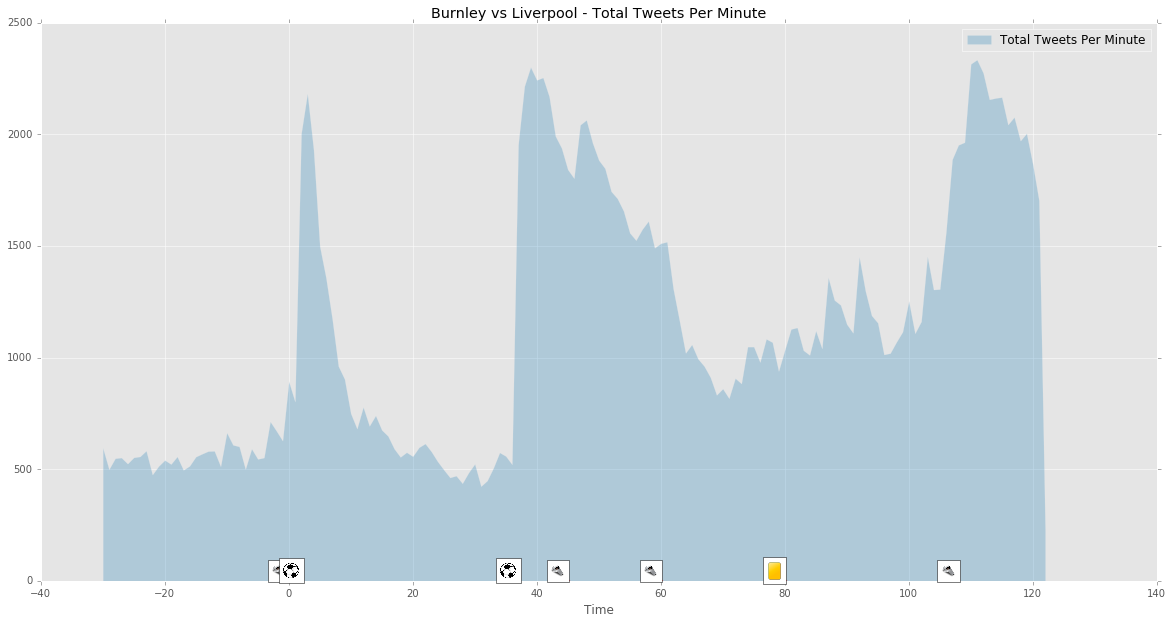

In [26]:
totalTweetsByMinute = getNumberOfTweets(game_df1)
startTime_Min = 24527940
MinuteList = game_df1.timeStampMinutes.unique()
x = [time - startTime_Min for time in MinuteList]

yList = [totalTweetsByMinute]
yListLabel =['Total Tweets Per Minute']
incident_dict = incident_dictLivBur
title = 'Burnley vs Liverpool - Total Tweets Per Minute'
xlabel ='Time'
ylabel = 'Tweets Per Minute'
isFill = True

getFigureWithPics(x,yList,yListLabel,incident_dict,title,xlabel,ylabel,isFill)


## Aggregate Sentiment Analysis Game 1

### x=0 ---> Game Start

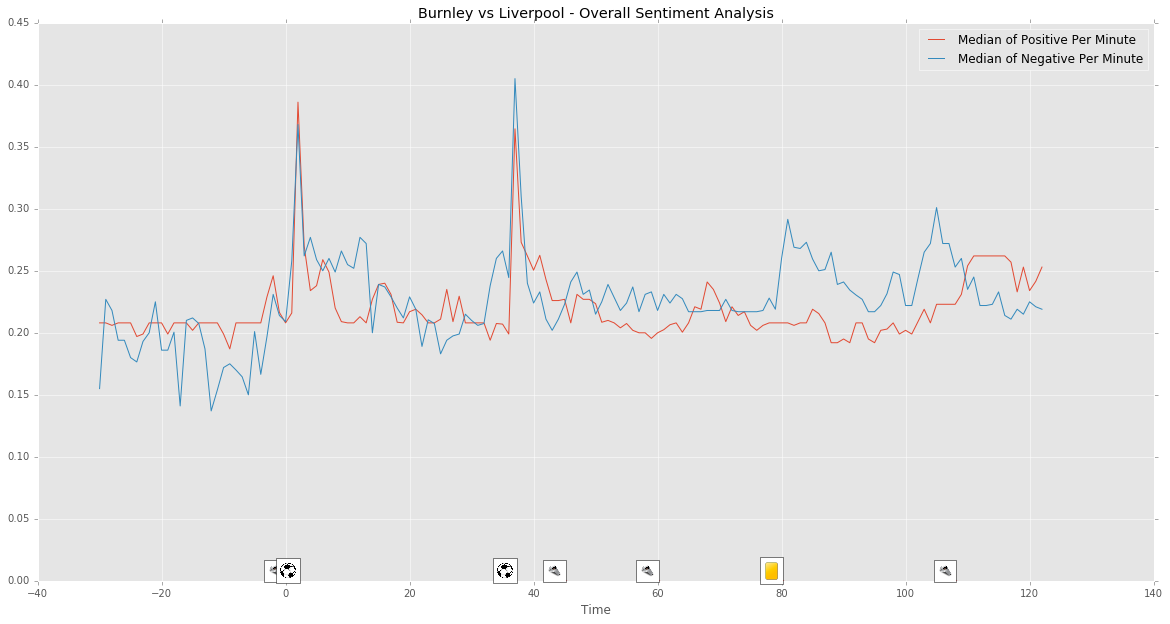

In [27]:
# Update StartTime_min of Every Game That you are analyzing

byMinutePercentPos, byMinutePercNeg, byMinuteMedianPos, byMinuteMedianNeg = getSummaryByMinute(game_df1)

startTime_Min = 24527940  # Check This for every game 
MinuteList = game_df1.timeStampMinutes.unique()
x = [time - startTime_Min for time in MinuteList]

yList = [byMinuteMedianPos,byMinuteMedianNeg]
yListLabel =['Median of Positive Per Minute','Median of Negative Per Minute']
incident_dict = incident_dictLivBur
title = 'Burnley vs Liverpool - Overall Sentiment Analysis'
xlabel ='Time'
ylabel = 'Median of Sentiment in the Group'

getFigureWithPics(x,yList,yListLabel,incident_dict,title,xlabel,ylabel,False)





## Sentiment Analysis Burnley
### x = 0 --> Game Start

/Users/deepakgautam/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


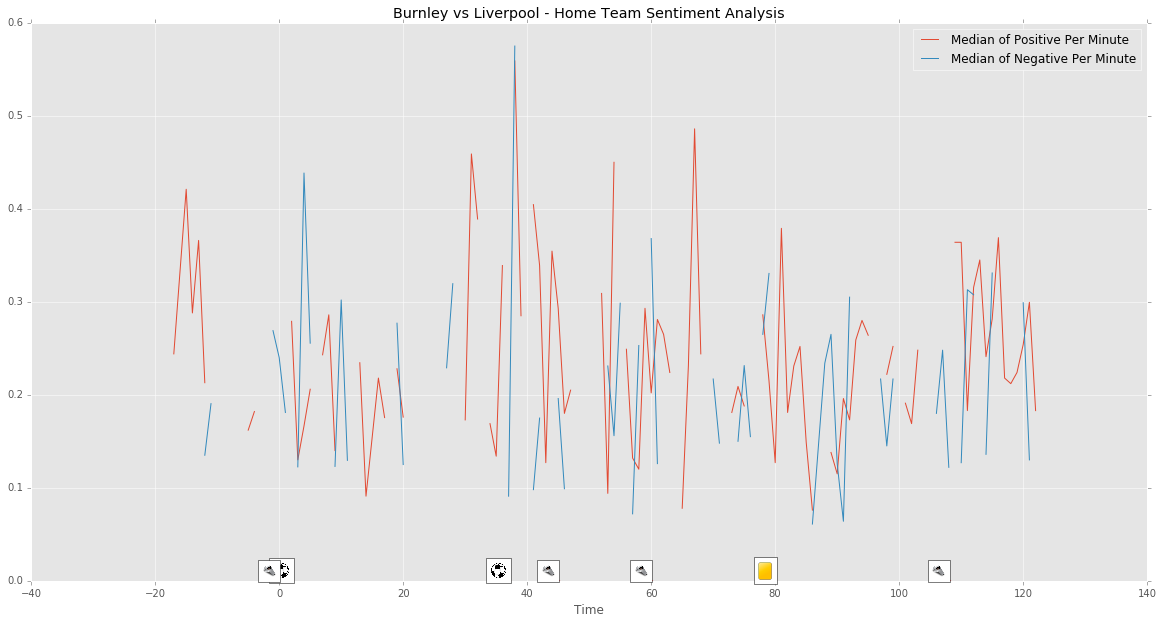

In [60]:
byMinutePercentPos, byMinutePercNeg, byMinuteMedianPos, byMinuteMedianNeg = getSummaryByMinute(home_df1)

startTime_Min = 24527940
MinuteList = home_df1.timeStampMinutes.unique()
x = [time - startTime_Min for time in MinuteList]

yList = [byMinuteMedianPos,byMinuteMedianNeg]
yListLabel =['Median of Positive Per Minute','Median of Negative Per Minute']
incident_dict = incident_dictLivBur
title = 'Burnley vs Liverpool - Home Team Sentiment Analysis'
xlabel ='Time'
ylabel = 'Median of Sentiment in the Group'

getFigureWithPics(x,yList,yListLabel,incident_dict,title,xlabel,ylabel)








## Sentiment Analysis Liverpool (Very Interesting)
### x = 0 --> Game Start

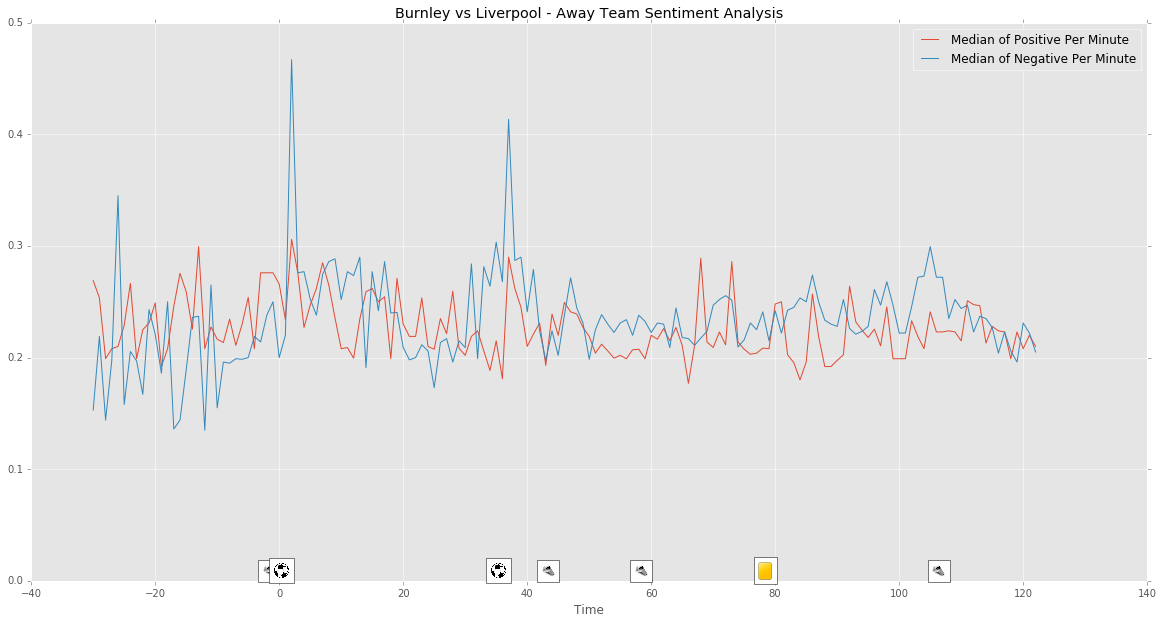

In [29]:
byMinutePercentPos, byMinutePercNeg, byMinuteMedianPos, byMinuteMedianNeg = getSummaryByMinute(away_df1)

startTime_Min = 24527940
MinuteList = away_df1.timeStampMinutes.unique()
x = [time - startTime_Min for time in MinuteList]

yList = [byMinuteMedianPos,byMinuteMedianNeg]
yListLabel =['Median of Positive Per Minute','Median of Negative Per Minute']
incident_dict = incident_dictLivBur
title = 'Burnley vs Liverpool - Away Team Sentiment Analysis'
xlabel ='Time'
ylabel = 'Median of Sentiment in the Group'

getFigureWithPics(x,yList,yListLabel,incident_dict,title,xlabel,ylabel)




## Game 2:  Leicester Vs Arsenal 

In [30]:

client = MongoClient()
db = client.TwitterDatabase

filtQuery = {}
colQuery = {'id_':1, 'text':1, 'user.text':1, 'user.name':1,'timestamp_ms':1, 'user.screen_name':1,'user.description':1}
main_df = read_mongo('LcfcArs',filtQuery,colQuery)

tcStartTime = 'August 20, 2016 9:00 AM'
tcEndTime = 'August 21, 2016 12:30 PM'

game_df2, home_df2, away_df2 = getFinaldfs(main_df,LeicesterKeys,ArsenalKeys,tcStartTime,tcEndTime)



### Incident Dictionary Game 2 

In [31]:
incident_dictLcfcArs = {'gameStart':[0],
                 'gameEnd':[108],
                 'halfTimeStart':[47],
                 'halfTimeEnd':[63],
                 'yellowCard':[24,45,90]
                }
startTime_MinLcfcArs = 24528090

## Total Tweet Analysis Game 2

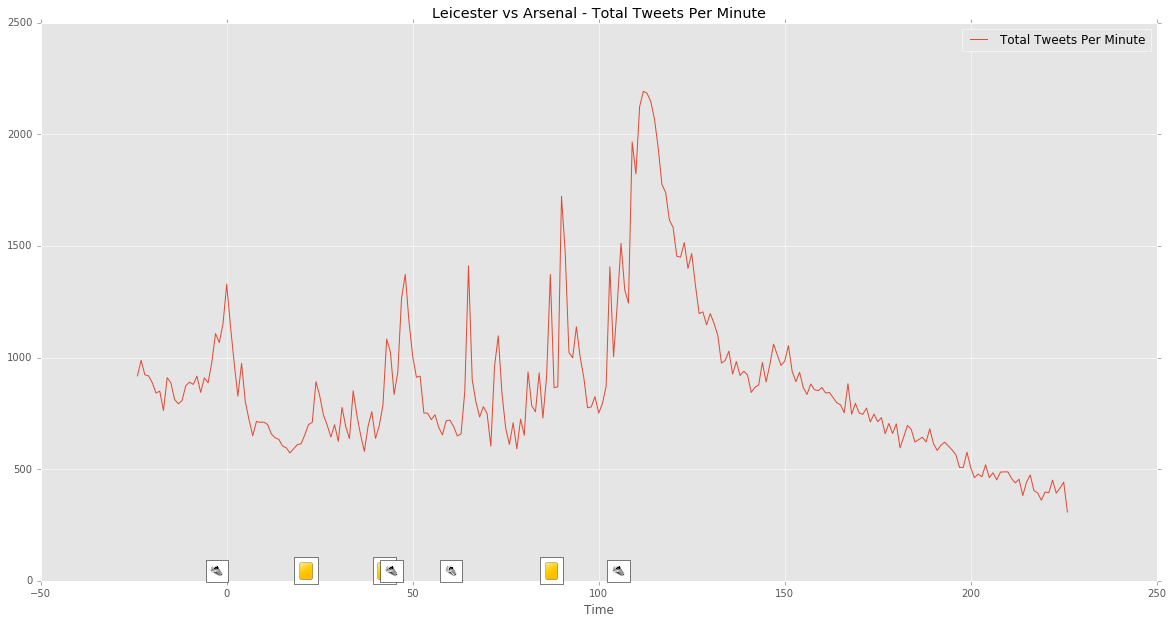

In [32]:
totalTweetsByMinute = getNumberOfTweets(game_df2) #update df

totalTweetsByMinute = getNumberOfTweets(game_df2)
startTime_Min = startTime_MinLcfcArs
MinuteList = game_df2.timeStampMinutes.unique()
x = [time - startTime_Min for time in MinuteList]

yList = [totalTweetsByMinute]
yListLabel =['Total Tweets Per Minute']
incident_dict = incident_dictLcfcArs
title = 'Leicester vs Arsenal - Total Tweets Per Minute'
xlabel ='Time'
ylabel = 'Tweets Per Minute'

getFigureWithPics(x,yList,yListLabel,incident_dict,title,xlabel,ylabel)


## Game 2 Sentiment Analysis

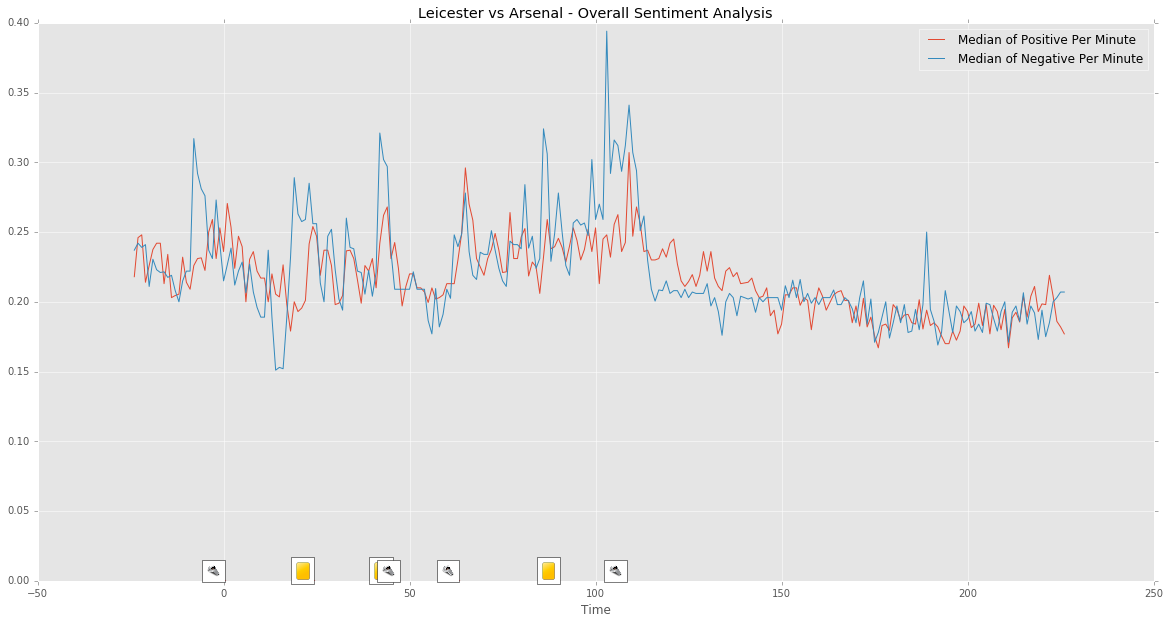

In [33]:
# Update StartTime_min of Every Game That you are analyzing

byMinutePercentPos, byMinutePercNeg, byMinuteMedianPos, byMinuteMedianNeg = getSummaryByMinute(game_df2)

startTime_Min = startTime_MinLcfcArs  # Check This for every game 
MinuteList = game_df2.timeStampMinutes.unique()
x = [time - startTime_Min for time in MinuteList]

yList = [byMinuteMedianPos,byMinuteMedianNeg]
yListLabel =['Median of Positive Per Minute','Median of Negative Per Minute']
incident_dict = incident_dictLcfcArs
title = 'Leicester vs Arsenal - Overall Sentiment Analysis'
xlabel ='Time'
ylabel = 'Median of Sentiment in the Group'

getFigureWithPics(x,yList,yListLabel,incident_dict,title,xlabel,ylabel)




/Users/deepakgautam/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


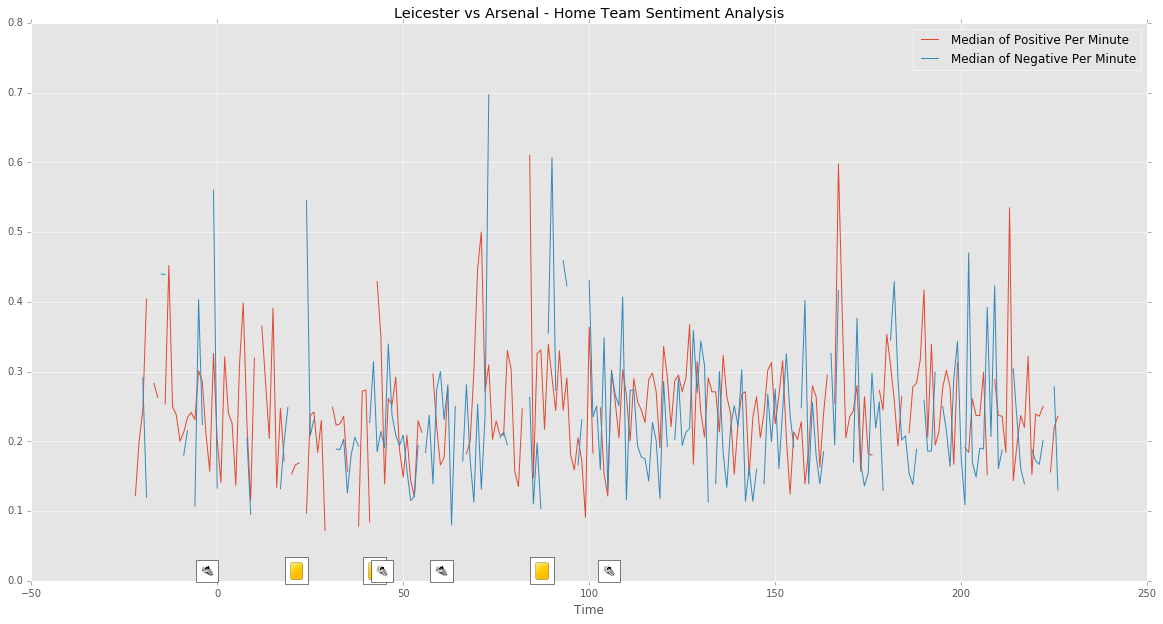

In [34]:

# Update StartTime_min of Every Game That you are analyzing

byMinutePercentPos, byMinutePercNeg, byMinuteMedianPos, byMinuteMedianNeg = getSummaryByMinute(home_df2)

startTime_Min = startTime_MinLcfcArs  # Check This for every game 
MinuteList = home_df2.timeStampMinutes.unique()
x = [time - startTime_Min for time in MinuteList]

yList = [byMinuteMedianPos,byMinuteMedianNeg]
yListLabel =['Median of Positive Per Minute','Median of Negative Per Minute']
incident_dict = incident_dictLcfcArs
title = 'Leicester vs Arsenal - Home Team Sentiment Analysis'
xlabel ='Time'
ylabel = 'Median of Sentiment in the Group'

getFigureWithPics(x,yList,yListLabel,incident_dict,title,xlabel,ylabel)





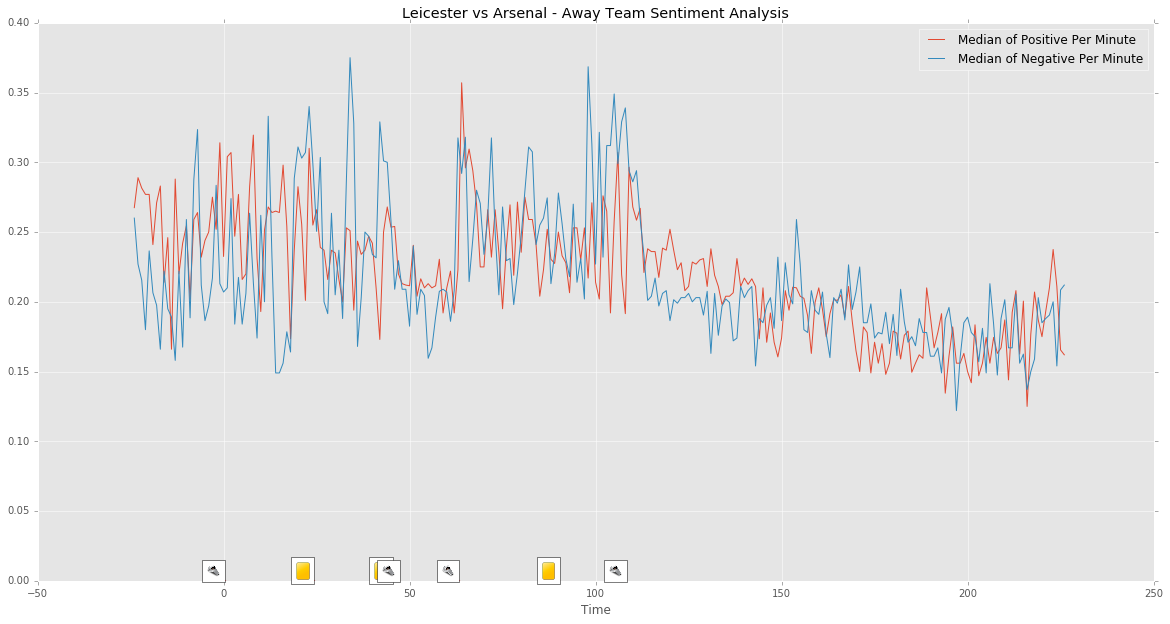

In [35]:



# Update StartTime_min of Every Game That you are analyzing

byMinutePercentPos, byMinutePercNeg, byMinuteMedianPos, byMinuteMedianNeg = getSummaryByMinute(away_df2)

startTime_Min = startTime_MinLcfcArs  # Check This for every game 
MinuteList = away_df2.timeStampMinutes.unique()
x = [time - startTime_Min for time in MinuteList]

yList = [byMinuteMedianPos,byMinuteMedianNeg]
yListLabel =['Median of Positive Per Minute','Median of Negative Per Minute']
incident_dict = incident_dictLcfcArs
title = 'Leicester vs Arsenal - Away Team Sentiment Analysis'
xlabel ='Time'
ylabel = 'Median of Sentiment in the Group'

getFigureWithPics(x,yList,yListLabel,incident_dict,title,xlabel,ylabel)






## Classification

***In order to see whether we can classify tweets to either Game 1 or Game 2 ***

In [36]:
# Setting 
game_df1['isGame1'] = pd.Series(1, index=game_df1.index)

game_df2['isGame1'] = pd.Series(0, index=game_df2.index)

merged_frame = [game_df1,game_df2]
merged_df = pd.concat(merged_frame)

In [38]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, \
roc_curve, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
import re
from xgboost import XGBClassifier

In [39]:
X = merged_df['text']
y = merged_df['isGame1']


In [40]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [41]:
class WordCount(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = []
        for text in X:
            s = len(text)
            feature.append([s])
        return feature
    def fit(self, X, y=None, **fit_params):
        return self



In [42]:
tfvectorizer = TfidfVectorizer(ngram_range = (1,2), min_df = 2, lowercase = False)
rfc = RandomForestClassifier(n_estimators = 500)
model_lr = LogisticRegression()

In [43]:
the_pipe = Pipeline([('feature union', FeatureUnion([
                                            ("count_vect", TfidfVectorizer()),
                                            ('Word Count', WordCount())
                                            ])),
                     ('logistic', model_lr)])

the_pipe.fit(X_train, y_train)
#the_pipe.score(X_test,y_test)
y_pred = the_pipe.predict_proba(X_test)
roc_auc_score(y_test,y_pred[:,1])


0.98764487570514825

In [44]:
#game_df1[game_df1['timeStampMinutes']>24527941]